In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [ ]:
import xarray as xr
from utils.function_clns import subsetting_pipeline, prepare
import numpy as np

path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/NDVI/archive.eumetsat.int/umarf-gwt/onlinedownload/riccardo7/4859700/temp/time/ndvi_eumetsat.nc"
chunks ={'time': -1, "lat": 250, "lon":250}
ds_ndvi = xr.open_dataset(path, engine="netcdf4", chunks=chunks)

ds_ndvi = subsetting_pipeline(ds_ndvi).rename({"Band1":"ndvi"})
ds_ndvi["ndvi"] = xr.where(ds_ndvi["ndvi"]==255, np.NaN, ds_ndvi["ndvi"])
ndvi = ds_ndvi["ndvi"]/100

In [ ]:
import pandas as pd
import xesmf as xe
ndvi = prepare(ndvi)

regridder = xe.Regridder(ndvi, dataset, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(ndvi)
ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(dataset.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
dataset['time'] = pd.to_datetime(dataset['time'].values, format='%Y-%m-%d')
dataset['time'] =  dataset.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], dataset['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered_1 = dataset.sel(time=common_times)
ds_2_filtered_1 = ds_reprojected.sel(time=common_times)

In [ ]:
import xskillscore as xs
corr_1 = xs.pearson_r(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
rmse_1 = xs.rmse(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
mae_1 = xs.mae(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
mape_1 = xs.mape(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)

In [ ]:
corr_1.transpose("lat","lon").plot(vmin=0)

In [ ]:
rmse_1.transpose("lat","lon").plot(vmax=0.2)

In [ ]:
print("mean correlation is", corr_1.mean().values)
print("mean rmse is", rmse_1.mean().values)
print("mean mae is", mae_1.mean().values)
print("mean mape is", mape_1.mean().values)

### LAI

In [ ]:
from utils.function_clns import config 
import os
import xarray as xr

chunks ={'time': -1, "lat": 250, "lon":250}

path_lai = config["LAI"]["path"]
lai = xr.open_mfdataset(os.path.join(path_lai, "*.nc"), chunks=chunks)

from utils.function_clns import subsetting_pipeline
lai_ds = subsetting_pipeline(lai)

import pandas as pd
import xesmf as xe
lai_ds = prepare(lai_ds)

regridder = xe.Regridder(dataset, lai_ds, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(dataset)
#ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(lai_ds.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
lai_ds = lai_ds.drop_duplicates(dim=["time"])

#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
lai_ds['time'] = pd.to_datetime(lai_ds['time'].values, format='%Y-%m-%d')
lai_ds['time'] =  lai_ds.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], lai_ds['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = lai_ds.sel(time=common_times).chunk(chunks)
ds2_filtered = ds_reprojected.sel(time=common_times).chunk(chunks)

## NDVI 10

In [7]:
import xarray as xr 
import os
from vegetation.preprocessing.ndvi_prep import load_landsaf_ndvi

path = "/media/BIFROST/N2/Riccardo/output"
target_store = "output_file.zarr"
zarr_path = os.path.join(path, target_store)
ds = load_landsaf_ndvi(zarr_path)

ERROR:fiona._env:PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from anot

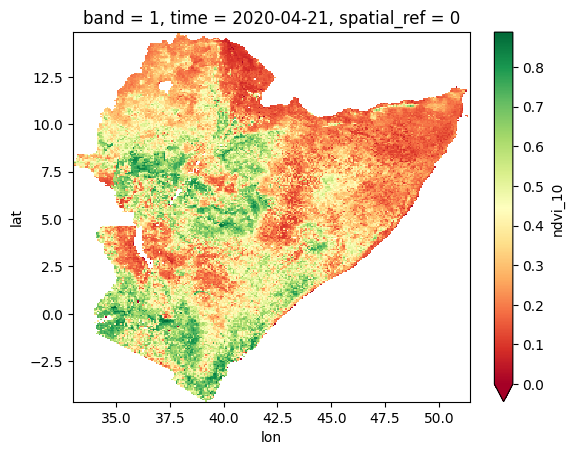

In [8]:
import numpy as np
ds.ndvi_10.isel(time=443).plot(cmap="RdYlGn", vmin=0)

In [ ]:
import pandas as pd



In [ ]:
import pandas as pd
import xesmf as xe
from utils.function_clns import prepare

print(final_dataset.rio.resolution())
print(ds.rio.resolution())

chunks ={'time': -1, "lat": 250, "lon":250}


repr_ds = prepare(final_dataset)
regridder = xe.Regridder(repr_ds, ds, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(repr_ds)
#ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(ds.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
ds = ds.drop_duplicates(dim=["time"])

#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
ds['time'] = pd.to_datetime(ds['time'].values, format='%Y-%m-%d')
ds['time'] =  ds.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], ds['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = ds.sel(time=common_times).chunk(chunks)
ds2_filtered = ds_reprojected.sel(time=common_times).chunk(chunks)
ds2_filtered = xr.where(ds1_filtered.ndvi_10.isnull(), np.NaN, ds2_filtered)

In [ ]:
import xskillscore as xs
corr_10 = xs.pearson_r(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
rmse_10 = xs.rmse(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
mae_10 = xs.mae(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
mape_10 = xs.mape(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)

In [ ]:
corr_10.plot(vmin=0)

In [ ]:
rmse_10.plot(vmax=0.4, vmin=0)

In [ ]:
print("mean correlation is", corr_10.mean().values)
print("mean rmse is", rmse_10.mean().values)
print("mean mae is", mae_10.mean().values)
print("mean mape is", mape_10.mean().values)

### Time series

In [ ]:
ndvi_seviri_mean = ds1_filtered_1.mean(["lat","lon"]) ## ours
ndvi_eumetsat_mean = ds_2_filtered_1.mean(["lat","lon"]) ## eumetsat ndvi

In [ ]:
ndvi_seviri_mean.plot(color="red")
ndvi_eumetsat_mean.plot(color="green")

In [ ]:
ndvi_10_lsaf = ds1_filtered.ndvi_10.mean(["lat","lon"]) ## landsaf ndvi
ndvi_10 = ds2_filtered.mean(["lat","lon"]) ## ours ndvi 10 days

In [ ]:
ds2_filtered.isel(time=0).plot(vmin=0, cmap="RdYlGn")

In [ ]:
ds1_filtered.ndvi_10.isel(time=0).plot(vmin=0, cmap="RdYlGn")

In [ ]:
ds.ndvi_10.mean(["time"]).plot(vmin=0, cmap="RdYlGn")

In [ ]:
time_min="2010-01-01"
time_max="2010-12-31"
lat = 6
lon= 37.5

ds.ndvi_10.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")

In [ ]:
time_min="2010-01-01"
time_max="2010-12-31"
lat = 7.5
lon= 36
ds2_filtered.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")
ds1_filtered.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).ndvi_10.plot(color="green")

In [ ]:
from vegetation.analysis.indices import compute_vci

vci_lsaf = compute_vci(ds1_filtered.ndvi_10)
vci_ours = compute_vci(ds2_filtered)

In [ ]:
time_min="2018-01-01"
time_max="2019-12-31"
lat = 6
lon= 39
vci_ours.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")
vci_lsaf.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="green")

In [ ]:
from analysis.visualizations.viz_vci_spi import get_subplot_year, box_plot_year
years = [i for i in np.arange(2008, 2020)]


df_list_1, list_dates_1 = get_subplot_year(ds = ds1_filtered.ndvi_10.to_dataset(name="ndvi"), 
                                        var="ndvi", year=years)

df_list, list_dates = get_subplot_year(ds = ds2_filtered.to_dataset(name="ndvi"), 
                                        var="ndvi", year=years)

In [ ]:
def plot_climatology(df_list, list_dates):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2) 

    # the first subplot
    ax0 = fig.add_subplot(gs[0])
    #ax0.set_title("NDVI for 2009")
    ax0.set_ylabel("NDVI value", fontsize=9)
    ax0.set_xlabel("Day of the year", fontsize=9)

    line0 = ax0.boxplot(df_list, showfliers=False, 
                patch_artist=True, 
                labels=list_dates, 
                showmeans=False,
                medianprops=dict(color="green",ls="--",lw=1), 
                positions=np.arange(0, len(df_list)*0.1, 0.1),
                meanline=True) 
                # meanprops=dict(color="red", ls="-", lw=2))

    n=15
    for ax in [ax0]:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='grey', linestyle='dashed')
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]
        ax.tick_params(labelrotation=45, tick1On=False)

    for med in line0['medians']:
        med.set_color('red')

    for box in line0["boxes"] :
        box.set_color("lightgrey")
        box.set_alpha(0.8)

    for whisk in line0["whiskers"]:
        whisk.set_color("green")

    gs.tight_layout(fig, rect=[0, 0, 1, 0.95])

In [ ]:
plot_climatology(df_list_1, list_dates_1)

In [ ]:
plot_climatology(df_list, list_dates)

In [ ]:
ndvi_10_lsaf.plot(color="green")
ndvi_10.plot(color="red")

In [ ]:
import matplotlib.pyplot as plt

def plot_random_points_over_time(data_array1, data_array2):

    lat = data_array1["lat"].values
    lon = data_array1["lon"].values

    def subset_with_random_points():
        # Get random latitude and longitude indices
        random_lat = np.random.choice(lat)
        random_lon = np.random.choice(lon)

        # Extract data for the random points
        random_point_data1 = data_array1.sel(lat=random_lat, lon=random_lon)
        random_point_data2 = data_array2.sel(lat=random_lat, lon=random_lon)
        return random_point_data1, random_point_data2, random_lat, random_lon
    
    random_point_data1, random_point_data2, random_lat, random_lon = subset_with_random_points()

    while random_point_data1.isnull().all() == True:
        random_point_data1, random_point_data2, random_lat, random_lon = subset_with_random_points()

    # Create a time array
    time = data_array1.time.values

    # Plot the random points over time
    plt.figure(figsize=(10, 6))
    plt.plot(time, random_point_data1, label='Reference', marker='o', color="green")
    plt.plot(time, random_point_data2, label='Calculated', marker='o',color="red")

    # Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f"Lat {round(random_lat,2)} Lon {round(random_lon,2)} Over Time")
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
plot_random_points_over_time(ds1_filtered.ndvi_10, ds2_filtered)

In [ ]:
time_min = "2015-01-01"
time_max = "2019-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

In [ ]:
time_min = "2015-01-01"
time_max = "2019-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

In [ ]:
time_min = "2012-01-01"
time_max = "2016-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

In [ ]:
lat = 3.13
lon = 37.06

ds_2_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="green")
ds1_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="red")

### Another lat lon point with good smoothing in the area with high rmse

In [ ]:
lat = 0
lon = 37.06

ds_2_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="green")
ds1_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="red")

### Max NDVI

In [ ]:
import xarray as xr
from utils.function_clns import subsetting_pipeline, prepare
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from vegetation.preprocessing.ndvi_prep import load_eumetsat_ndvi_max


filepath = os.path.join(config["NDVI"]["ndvi_path"], "seviri_daily_ndvimax.nc")
max_ndvi = load_eumetsat_ndvi_max(filepath)

In [ ]:
import pandas as pd
import xesmf as xe
max_ndvi = prepare(max_ndvi)

regridder = xe.Regridder(max_ndvi, dataset, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(max_ndvi)
ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(dataset.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
dataset['time'] = pd.to_datetime(dataset['time'].values, format='%Y-%m-%d')
dataset['time'] =  dataset.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], dataset['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered_max = dataset.sel(time=common_times).chunk({"time": -1, "lat":50, "lon":50})
ds_2_filtered_max = ds_reprojected.sel(time=common_times).chunk({"time":-1, "lat":50, "lon":50})

In [ ]:
time_min="2013-01-01"
time_max="2013-12-31"
lat = 7.5
lon= 36
ds1_filtered_max.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")
ds_2_filtered_max.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="green")

In [ ]:
ds_2_filtered_max.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="green")

In [ ]:
ds1_filtered_max.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")

In [ ]:
import xskillscore as xs
corr_max = xs.pearson_r(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
rmse_max = xs.rmse(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
mae_max = xs.mae(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
mape_max = xs.mape(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)

In [ ]:
print("mean correlation is", corr_max.mean().values)
print("mean rmse is", rmse_max.mean().values)
print("mean mae is", mae_max.mean().values)
print("mean mape is", mape_max.mean().values)

In [ ]:
corr_max.transpose("lat","lon").plot(vmin=0)

In [ ]:
rmse_max.transpose("lat","lon").plot(vmax=0.3)

#### Modifying NDVI max 

In [ ]:
# Sample calculation function
def apply_ndvi_conversion(ndvi_data):
    ndvi_data[np.isnan(ndvi_data)] = -2
    ndvi_data = np.floor((ndvi_data + 1) * 128)  # [-1 1] -> [0 256]
    ndvi_data[ndvi_data > 255] = 255
    ndvi_data[ndvi_data < 0] = 0
    return np.uint8(ndvi_data)  # change data type from double to uint8

def scale_ndvi(ndvi):
    scaled_ndvi = ((ndvi + 1) * 127)
    scaled_ndvi = xr.where(scaled_ndvi.isnull(), 255, scaled_ndvi)
    return scaled_ndvi.astype(int)

# Apply the function to the NDVI data variable in the dataset
# Create a new dataset with the transformed NDVI values
ds_transformed = dataset.copy()

ds_converted= scale_ndvi(ds_transformed)
ds_converted = xr.where(ds_converted==255, np.NaN, ds_converted)
ds_converted = (ds_converted/254)

In [ ]:
ds_converted.plot()

In [ ]:
norm_ndvi = (ds1_filtered_max - ds1_filtered_max.min())/(ds1_filtered_max.max() - ds1_filtered_max.min())
zero_ndvi = xr.where(ds1_filtered_max < 0, 0, ds1_filtered_max)

### Calculate histogram differences
diff_ndvi = ds_converted - ds_2_filtered_max
diff_ndvi_orig = ds1_filtered_max - ds_2_filtered_max
diff_ndvi_norm = norm_ndvi - ds_2_filtered_max
diff_zero_ndvi = zero_ndvi - ds_2_filtered_max

In [ ]:
diff_ndvi_orig.plot() ## no modification

In [ ]:
diff_zero_ndvi.plot() ### imputing to zero all the negative values

In [ ]:
diff_ndvi_norm.plot()  ### normalizing NDVI from 0 to 1

In [ ]:
diff_ndvi.plot()  ### converting NDVI to 0-255

#### Checking correspondence between predicted and real max NDVI

In [ ]:
corr_mask = xr.where(corr_max>=0.75, 1, 0)

In [ ]:
# Extract predicted and real values
predicted_values = ds1_filtered_max.where(cover_ptg<0.6).values.flatten()
real_values = ds_2_filtered_max.where(cover_ptg<0.6).values.flatten()

arr1 = predicted_values[~np.isnan(predicted_values)]
arr2 = real_values[~np.isnan(real_values)]

In [ ]:
# Create histogram
hist1, bins1 = np.histogram(arr1, bins=1000, density=True)
# Compute cumulative sum
cumulative = np.cumsum(hist1)
# Normalize cumulative sum
ecdf1 = cumulative / np.max(cumulative)

# Create histogram
hist2, bins2 = np.histogram(arr2, bins=1000, density=True)
# Compute cumulative sum
cumulative = np.cumsum(hist2)
# Normalize cumulative sum
ecdf2 = cumulative / np.max(cumulative)


import matplotlib.pyplot as plt

# Plot ECDF
plt.plot(bins1[1:], ecdf1, marker='.', linestyle='-', label='ECDF', color="green")
plt.plot(bins2[1:], ecdf2, linestyle='dashed', label='ECDF', color="red")
plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.show()

In [ ]:
sorted_da1 = np.sort(predicted_values)
sorted_da2 = np.sort(real_values)
import matplotlib.pyplot as plt
# Create a quantile plot
plt.figure(figsize=(6, 6))
plt.scatter(sorted_da1, sorted_da2, color='blue')
plt.xlabel('Quantiles of DataArray 1')
plt.ylabel('Quantiles of DataArray 2')
plt.title('QQ Plot')
plt.grid(True)
plt.show()

In [ ]:
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='Blues')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='inferno')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### Raw vegetation data

In [ ]:
res_xr = xr.open_dataset(os.path.join(
    config["NDVI"]["ndvi_prep"],"final_ndvi.nc"))

time_min = ds1_filtered_1.time.min().values
time_max = ds1_filtered_1.time.max().values

lat = 3.13
lon = 37.06
res_xr.sel(lat=lat, lon=lon, method="nearest")\
    .sel(time=slice(time_min,time_max))["ndvi"]\
        .plot(label="Raw NDVI", color="blue")

ds1_filtered_1.sel(lat=lat, lon=lon, 
                   method="nearest"
                   ).plot(color="red", label="Smoothed NDVI")

In [ ]:
from vegetation.analysis.NDVI_indices import compute_ndvi

ndvi_1 = compute_ndvi(res_xr["channel_1"], res_xr["channel_2"])

In [ ]:
ndvi_1.sel(lat=lat, lon=lon, method="nearest").plot()

In [ ]:
res_xr.channel_1.sel(lat=lat, lon=lon, method="nearest").plot()

In [ ]:
res_xr.channel_2.sel(lat=lat, lon=lon, method="nearest").plot()

### Cloudmask cleaning

In [ ]:
cloud_path = os.path.join(config['NDVI']['cloud_path'], 'nc_files/new/ndvi_mask.nc')
cloud_mask = xr.open_dataarray(cloud_path)
print(cloud_mask.rio.resolution())

ndvi_raw = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))

ndvi_raw["time"]= ndvi_raw.indexes["time"].normalize()
ndvi_raw = ndvi_raw.drop_duplicates(dim="time")

cloud_mask["time"]= cloud_mask.indexes["time"].normalize()
cloud_mask = cloud_mask.drop_duplicates(dim="time")

# Find the common time values between ds1 and ds2
common_times = xr.align(cloud_mask, ndvi_raw)
# Select only the common time values in ds1 and ds2
cloud_mask = common_times[0]
ndvi_raw = common_times[1]

ndvi_ds = ndvi_raw["ndvi"].to_dataset()
ndvi_ds = ndvi_ds.assign(cloud_mask = cloud_mask)

### calculate rolling cloud and % of cloud measures
rolling_cloud = xr.where(cloud_mask==2,1,0)\
    .rolling(time=180).sum()

cl_mk =xr.where(cloud_mask==2,1,0)
cover_ptg = (cl_mk.sum(["time"])/cl_mk.count(["time"]))

In [ ]:
cover_ptg.where(cover_ptg<0.6).plot()

In [ ]:
cover_ptg.plot()

In [ ]:
import xskillscore as xs
corr_max_clean = xs.pearson_r(ds1_filtered_max.where(cover_ptg<0.6), 
                        ds_2_filtered_max.where(cover_ptg<0.6), dim="time", skipna=True)

rmse_max_clean = xs.rmse(ds1_filtered_max.where(cover_ptg<0.6), 
                        ds_2_filtered_max.where(cover_ptg<0.6), dim="time", skipna=True)
print("mean correlation is", corr_max_clean.mean().values)

In [ ]:
print("mean rmse is", rmse_max_clean.mean().values)

In [ ]:
rmse_max_clean.transpose("lat", "lon").plot(vmax=0.4)

In [ ]:
corr_max_clean.transpose("lat", "lon").plot(vmin=0.4)

In [ ]:
lon = 36
lat = 7.5
time_min = "2015-01-01"
time_max = "2016-01-01"
ndvi_raw.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).channel_1.plot(color="red")
ds1_filtered_max.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="blue")
ndvi_raw.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).channel_2.plot(color="yellow")


In [ ]:
lon = 37.5
lat = 12.5
time_min = "2015-01-01"
time_max = "2016-01-01"
ndvi_raw.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).channel_1.plot(color="red")
ds1_filtered_max.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="green")
ndvi_raw.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).channel_2.plot(color="yellow")



### Testing smoother

In [ ]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """
    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin][s_mid]]
    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

def interpolate_nan(array_like):
    array = array_like.copy()

    isnan_array = ~np.isnan(array)

    xp = isnan_array.ravel().nonzero()[0]

    fp = array[~np.isnan(array)]
    x = np.isnan(array).ravel().nonzero()[0]

    array[np.isnan(array)] = np.interp(x, xp, fp)

    return array

In [ ]:
def ED_SG(series, formatted_dates=None, plot=True):
    from scipy.signal import savgol_filter
    import matplotlib.dates as mdates

    low_idx, high_idx = hl_envelopes_idx(series)
    
    # Create a boolean mask indicating which indices to nullify
    mask = np.zeros_like(series, dtype=bool)
    mask[high_idx] = True
    
    # Use np.where() to preserve values at certain indices
    masked_arr = np.where(np.isin(np.arange(len(series)), high_idx), series, np.nan)
    
    new_arr = interpolate_nan(masked_arr)
    
    smoothed_array = savgol_filter(new_arr, 15, 3, axis=0)
    
    if plot is True:
        # plot
        # plt.plot(formatted_dates,y_corr,label='signal')
        # plt.plot(formatted_dates[high_idx], y_corr[high_idx], 'r', label='low')
        plt.plot(formatted_dates, new_arr , color= 'grey', label='high')
        plt.plot(formatted_dates, smoothed_array, 'blue', label='ED-SG')
    
        # Define the date formatter and set the interval for major ticks
        date_format = mdates.DateFormatter('%Y-%m')
        plt.gca().xaxis.set_major_formatter(date_format)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
    
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.legend()
    
        plt.show()

    return smoothed_array

In [ ]:
series = y 

low_idx, high_idx = hl_envelopes_idx(series)
    
# Create a boolean mask indicating which indices to nullify
mask = np.zeros_like(series, dtype=bool)
mask[high_idx] = True

# Use np.where() to preserve values at certain indices
masked_arr = np.where(np.isin(np.arange(len(series)), high_idx), series, np.nan)

new_arr = interpolate_nan(masked_arr)

smoothed_array = savgol_filter(new_arr, 15, 3, axis=0)

In [ ]:
from modape.whittaker import ws2doptv, ws2d, ws2doptvp
from array import array
from datetime import datetime
import matplotlib.dates as mdates
from scipy.signal import savgol_filter, hilbert, chirp
import numpy as np

lon = 36.75
lat = -0.1
time_min = "2015-01-01"
time_max = "2020-01-01"

y_temp = ndvi_raw.where(cloud_mask!=2, np.NaN).ndvi\
    .sel(lon=lon, lat = lat, method="nearest")\
    .sel(time=slice(time_min, time_max))

y = y_temp.values.astype(np.float32)
y_corr = np.where(np.isnan(y), 0, y) 
w = np.where(np.isnan(y), 0, 1)

dates = pd.to_datetime(y_temp.time.values)
formatted_dates = mdates.date2num(dates)

p = 0.99 
lambda_min=-2
lambda_max = 4

w_corr = w.astype(np.double)
y_corr_db = y_corr.astype(np.double)

z, sopt = ws2doptvp(y_corr_db, w_corr, 
                    array("d", np.arange(lambda_min, lambda_max, 0.2).round(2)), 
                    p=p)
z_arr =  np.array(z, dtype=np.float32)

ch1 = ndvi_raw.channel_1.sel(lon=lon, lat = lat, method="nearest")\
    .sel(time=slice(time_min, time_max))

ch2 = ndvi_raw.channel_2.sel(lon=lon, lat = lat, method="nearest")\
    .sel(time=slice(time_min, time_max))

sg = ED_SG(y, plot=False)

# Define the date formatter and set the interval for major ticks
date_format = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))

plt.plot(formatted_dates, z_arr, color = "green", alpha=0.7, label="WS")
plt.plot(formatted_dates, y, color = "black", alpha=1, label= "NDVI")
plt.plot(formatted_dates, ch1, color="violet", alpha=0.6 )
plt.plot(formatted_dates, ch2, color="red", alpha=0.3 )
plt.plot(formatted_dates, sg, color = "grey", alpha=0.5, label="ED-SG")

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.legend()
plt.show()

In [ ]:
streaks = []
current_streak = 0
for day in y:
    if np.isnan(day):
        current_streak += 1
    else:
        if current_streak > 0:
            streaks.append(current_streak)
            current_streak = 0

if current_streak > 0:
    streaks.append(current_streak)

# Step 2: Calculate length of each streak
total_length = sum(streaks)
num_streaks = len(streaks)

# Step 3: Calculate average
average_length = total_length / num_streaks
print("Average length of consecutive days with clouds:", round(average_length,1))
print("Max number of consecutive days with clouds:", max(streaks))
print("Std of consecutive days with clouds:", np.std(streaks))


In [ ]:
import obspy
import obspy.signal.filter
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, hilbert, chirp
import numpy as np

analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)

data_envelope = obspy.signal.filter.envelope(y)
smoothed_array = savgol_filter(data_envelope, 15, 3, axis=0)

# plt.plot(data_envelope, color = "blue", alpha=0.4)
plt.plot(y, color = "grey", alpha=0.3)
#plt.plot(smoothed_array, color="blue", alpha=0.5)
plt.plot(z_arr, color = "green", alpha=0.5)

In [ ]:
import os
from pathlib import Path
user = config["EARTHDATA"]["user"]
password = config["EARTHDATA"]["password"]


targetdir = Path(os.path.join(config["MODIS"]["download"], "MASK"))

if not os.path.exists(targetdir):
    os.makedirs(targetdir)

### Load MODIS NDVI

In [16]:
from utils.xarray_functions import add_time_tiff
import os
import xarray as xr
from utils.function_clns import subsetting_pipeline, prepare, config

chunks = {"time":"auto", "lat":"auto", "lon":"auto"}

base_path = "/media/woden/DATI1/Riccardo"

def load_generate_modis(source_path:str, 
                        output_path:str, 
                        chunks:dict):
    if os.path.isfile(output_path):
        modis_ds = xr.open_zarr(output_path, chunks=chunks)
    else:

        files = [os.path.join(source_path, f) for f in os.listdir(source_path) if f.endswith(".tif")]
        ds = xr.open_mfdataset(files,engine="rasterio", 
                               parallel=True, 
                               preprocess=add_time_tiff,
                               chunks=chunks)
        ds = ds.isel(band=0)
        ds = ds.rename({"band_data":"ndvi"})
        modis_ds = ds.drop("band")

    from dask.diagnostics import ProgressBar
    with ProgressBar():
        modis_ds.to_zarr(output_path)

    return modis_ds

In [21]:
modis_path = os.path.join(base_path, "MOD09GA_ndvi.zarr")
modis_files_path = config["MODIS"]["NDVI_06"]["output_dir"]

modis_ds = load_generate_modis(modis_files_path, 
                               modis_path, 
                               chunks=chunks)

[########################################] | 100% Completed | 3hr 18m


### Create SEVIRI composite

In [2]:
import os
import xarray as xr
from utils.xarray_functions import add_time, compute_radiance
from vegetation.analysis.indices import compute_ndvi
from utils.function_clns import subsetting_pipeline
from utils.function_clns import config
import logging
from dask.diagnostics import ProgressBar
import pyproj
from vegetation.preprocessing.ndvi_prep import apply_seviri_cloudmask, remove_ndvi_outliers, NDVIPreprocess

chunks = {"time":"auto", "lat":"auto", "lon":"auto"}

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [64]:
cloud_dir = config["NDVI"]["cloud_path"]
hour_folder = "12_15"
cloud_path = os.path.join(cloud_dir, hour_folder)
files = [f for f in os.listdir(cloud_path) if f.endswith(".nc")]
file_list = [os.path.join(cloud_path, f) for f in os.listdir(cloud_path) if f.endswith(".nc")]

In [65]:
from datetime import datetime
dates = [datetime.strptime(file.split('_')[1], '%Y%m%dT%H%M%SZ').strftime('%Y-%m-%d') for file in files]

In [66]:
from collections import Counter

# Assuming 'dates' is the list of dates obtained from the previous step
date_counts = Counter(dates)

repeated_dates = {date: count for date, count in date_counts.items() if count > 1}

if repeated_dates:
    print("Repeated dates found:")
    for date, count in repeated_dates.items():
        print(f"{date}: {count} occurrences")
else:
    print("No repeated dates found.")

Repeated dates found:
2005-04-01: 2 occurrences
2005-05-02: 2 occurrences
2005-09-01: 2 occurrences
2006-04-23: 2 occurrences
2006-06-22: 2 occurrences
2006-08-09: 2 occurrences
2007-03-14: 2 occurrences
2007-06-14: 2 occurrences
2009-06-05: 2 occurrences
2011-02-28: 2 occurrences
2011-07-14: 2 occurrences
2011-09-15: 2 occurrences
2012-02-28: 2 occurrences
2012-02-29: 2 occurrences
2012-03-01: 2 occurrences
2012-04-05: 2 occurrences
2013-03-02: 2 occurrences
2013-09-11: 2 occurrences
2014-03-02: 2 occurrences
2014-03-03: 2 occurrences
2014-03-04: 2 occurrences
2014-04-30: 2 occurrences
2015-01-05: 2 occurrences
2015-03-01: 2 occurrences
2015-03-02: 2 occurrences
2015-03-03: 2 occurrences
2015-10-18: 2 occurrences
2016-02-27: 2 occurrences
2016-02-28: 2 occurrences
2016-02-29: 2 occurrences
2016-07-08: 2 occurrences
2017-08-06: 2 occurrences
2017-10-24: 2 occurrences
2018-01-01: 2 occurrences
2018-11-23: 2 occurrences
2019-01-29: 2 occurrences
2019-07-28: 2 occurrences
2020-03-04: 2 oc

In [67]:
# Iterate over the repeated dates
for date, count in repeated_dates.items():
    # Find indices of files with the repeated date
    indices = [i for i, d in enumerate(dates) if d == date]
    # Sort indices based on the file creation time, assuming files are named in chronological order
    indices.sort(key=lambda i: os.path.getctime(file_list[i]))
    # Remove the older files
    for i in indices[:-1]:
        print(f"Removing file: {file_list[i]}")
        os.remove(file_list[i])

Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20050401T121500Z_20050401T121500Z_epct_3a46f491_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20050502T121500Z_20050502T121500Z_epct_4d31d84c_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20050901T121500Z_20050901T121500Z_epct_5461f198_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20060423T121500Z_20060423T121500Z_epct_e33a6aa1_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20060622T121500Z_20060622T121500Z_epct_56e92146_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20060809T121500Z_20060809T121500Z_epct_58de997b_FPC.nc
Removing file: /media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/12_15/MSGCLMK_20070314T121500Z_20070314T121500Z_epct_2226ad0a_FPC.nc
Removi

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
INFO:root:Processing SEVIRI data for hour 12_15
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(
INFO:root:Applying cloudmask for hour 12_15
INFO:root:Processing SEVIRI data for hour 09_15
INFO:root:Applying cloudmask for hour 09_15
INFO:root:Processing SEVIRI data for hour 10_30
INFO:root:Applying cloudmask for hour 10_30


In [54]:
from utils.xarray_functions import _extract_dates, _output_dates
import numpy as np
import pandas as pd
dates = _extract_dates(datasets[0])
expected_dates = _output_dates("P1D", dates[0],dates[-1])
missing_dates = [f for f in expected_dates if f not in dates]

/tmp/ipykernel_1612046/326852326.py:19: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return datetime.utcfromtimestamp((t - np.datetime64("1970-01-01T00:00:00Z")) / np.timedelta64(1, "s"))


In [ ]:
with ProgressBar():
    ds_final.to_zarr(os.path.join(base_path, "seviri_daily_composite.zarr"))

In [ ]:
from vegetation.data_collection.seviri import datatailor_loop
from tqdm.auto import tqdm

product_code = config['SEVIRI']['cloud']
folder = "12_15"

for d in tqdm(missing_dates):
    start_date = f"{d.year}-{d.month}-{d.day} 11:55:00"
    datatailor_loop(product_code, start_date=start_date, end_date=start_date, destfoldername=folder)

In [ ]:
list_files = []
for f in files:
    d = xr.open_dataset(f)
    if len(d.lat)!=644:
        print("File {} is different".format(f.split("/")[-1]))
        list_files.append(f)

In [12]:
import pandas as pd
name = "MSG1-SEVI-MSGCLMK-0100-0100-20050101121500.000000000Z-NA.grb"

def extract_time(name):
    name.split("/")[-1]

    # Define the regex pattern to match the date and time
    pattern = r'(\d{4}\d{2}\d{2})(\d{2}\d{2}\d{2})'

    # Use re.search() to find the pattern in the string
    match = re.search(pattern, name)

    if match:
        start_date = match.group(1)
        print(start_date)
        start_time = match.group(2)
        start_datetime = pd.to_datetime(start_date + start_time, format='%Y%m%d%H%M%S')
        return start_datetime
    else:
        print("No match found.")
        return None

In [ ]:
filename = "ndvi_full_image.zarr"

baseline_path = config["DEFAULT"]["local"] #config["NDVI"]["ndvi_path"]
os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

ds_915 = xr.open_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename), 
                        chunks=chunks)

def _preprocess(ds):
    from utils.xarray_functions import add_time
    ds = add_time(ds)
    return ds

cloud_path = os.path.join(config["NDVI"]["cloud_path"], "09_15")
files = [os.path.join(cloud_path, file) for file in os.listdir(cloud_path) if file.endswith(".nc")]
with ProgressBar():
    cl_915 = xr.open_mfdataset(files, 
                        preprocess=_preprocess, 
                        engine='netcdf4', 
                        parallel=False, chunks=chunks)

logging.info("Loaded cloudmask")
ds_915 = apply_seviri_cloudmask(ds_915, cl_915)
logging.info("Applied cloudmask")
ds_915["ndvi"] = remove_ndvi_outliers(ds_915["ndvi"])
ds_915 = NDVIPreprocess(ds_915["ndvi"]).get_processed_data()

path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/12_30/batch_2/processed/new_process"
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".nc")]
ds_12 = xr.open_mfdataset(files, chunks=chunks, parallel=False)

batch3_path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/12_30/batch_3/*.nc"

def preprocess(ds):
    ds = add_time(ds)
    ds = compute_radiance(ds)
    return ds 

ds_new = xr.open_mfdataset(batch3_path, preprocess =preprocess, parallel=True, chunks=chunks)
ds_new = compute_ndvi(band2=ds_new["channel_2"],band1=ds_new["channel_1"])
ds_new = subsetting_pipeline(ds_new)
ds_1230 = xr.concat([ds_12["ndvi"], ds_new], dim="time")

### load and prepare cloudmask
base_dir = 'batch_2/nc_files/new/ndvi_mask.nc'
cl_df = xr.open_dataset(os.path.join(config['NDVI']['cloud_path'], base_dir), chunks=chunks)
cl_df = cl_df.sel(time=slice(cl_df['time'].min(), '2021-01-01'))

ds_1230 = apply_seviri_cloudmask(ds_1230, cl_df)
ds_1230 = remove_ndvi_outliers(ds_1230)
ds_1230 = NDVIPreprocess(ds_1230).get_processed_data()

In [ ]:
import xarray_beam as xbeam 
import xarray
from dataclasses import dataclass
import apache_beam as beam
from pangeo_forge_recipes.transforms import (
    OpenURLWithFSSpec, OpenWithXarray, StoreToZarr, Indexed, T
)

all_days = pd.date_range('2013-01-01', '2014-01-01', freq='1D')

def load_one_example(time: pd.Timestamp) -> tuple[xbeam.Key, xarray.Dataset]:
    key = xbeam.Key({'time': (time - all_days[0]).days})
    dataset = ds.sel(time=[time])  # replace with your code to create one example
    return key, dataset

_, example = load_one_example(all_days[0])
template = xbeam.make_template(example).squeeze('time', drop=True).expand_dims(time=all_days)
zarr_chunks = {'time': 100}  # desired chunking along "time", e.g., for more efficient storage in Zarr



@dataclass
class Preprocessor(beam.PTransform):
    """
    Preprocessor for xarray datasets.
    Set all data_variables except for `variable_id` attrs to coord
    Add additional information 

    """

    @staticmethod
    def _keep_only_variable_id(item: Indexed[T]) -> Indexed[T]:
        """
        Many netcdfs contain variables other than the one specified in the `variable_id` facet. 
        Set them all to coords
        """
        index, ds = item
        print(f"Preprocessing before {ds =}")
        new_coords_vars = [var for var in ds.data_vars if var != ds.attrs['variable_id']]
        ds = ds.set_coords(new_coords_vars)
        print(f"Preprocessing after {ds =}")
        return index, ds
    
    @staticmethod
    def _sanitize_attrs(item: Indexed[T]) -> Indexed[T]:
        """Removes non-ascii characters from attributes see https://github.com/pangeo-forge/pangeo-forge-recipes/issues/586"""
        index, ds = item
        for att, att_value in ds.attrs.items():
            if isinstance(att_value, str):
                new_value=att_value.encode("utf-8", 'ignore').decode()
                if new_value != att_value:
                    print(f"Sanitized datasets attributes field {att}: \n {att_value} \n ----> \n {new_value}")
                    ds.attrs[att] = new_value
        return index, ds
  
    def expand(self, pcoll: beam.PCollection) -> beam.PCollection:
        return ( pcoll 
            | "Fix coordinates" >> beam.Map(self._keep_only_variable_id)
            | "Sanitize Attrs" >> beam.Map(self._sanitize_attrs)
        )

with beam.Pipeline() as p:
    (
        p
        | beam.Create(all_days)
        | beam.Map(load_one_example)
        | xbeam.ConsolidateChunks(zarr_chunks)
        | xbeam.ChunksToZarr('example-data-v4.zarr', template, zarr_chunks)
    )